# Изучение гипотезы построения модели прогнозирования землетрясений на с использованием сверточных нейронных сетей KERAS

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.metrics import Precision, Recall, F1Score
from keras.utils import to_categorical
from sklearn.metrics import classification_report, r2_score

from parser.db import client
from parser.repo.handler import upload_df
from datafactory.cuter import split_stratified_into_train_val_test
from datafactory.generator import Enrichment

2023-07-05 15:10:26.334044: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-05 15:10:26.335364: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 15:10:26.362075: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 15:10:26.362842: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 15:10:27.049807: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## 1. Загрузка данных

#### В базе данных созданы две таблицы 
- quakes - базовая таблица с данными. Данные загружены инструментами ноутбука **upload.ipynb**. В таблице значение магнитуды имеют дробные значения - тип данных FLOAT.
- quakes_class - в данной таблице значения магнитуды округлены до целых значений. Таким образом мы имеем до 10 классов магнитуды в диапазоне от 0 до 9, данная таблица, формируется программно на основе ранее загруженных данных из таблицы quakes.

В случае если, таблица данных **quakes_class** не загружена в базу данных, необходимо раскоментировать строку upload_quake_class_bd()

In [2]:
def upload_quake_class_bd():
    ### Создание базы данных с целыми значениями магнитуды
    quakes_df: pd.DataFrame = client.query_df('SELECT * FROM quakes ORDER BY Date')
    quakes_class_df = quakes_df.copy()
    quakes_class_df['Magnitude'] = np.round(quakes_class_df['Magnitude'], decimals = 0)
    upload_df(quakes_class_df, table='quakes_class')
    upload_df(quakes_class_df, table='quakes_class_enrich')

upload_quake_class_bd()

None
None


In [3]:
# Загрузка данных
quakes_df: pd.DataFrame = client.query_df('SELECT * FROM quakes ORDER BY Date')
quakes_class_df: pd.DataFrame = client.query_df('SELECT * FROM quakes_class ORDER BY Date')

# Разбиение датасета на обучающий, валидационный и тестовый
df_train, df_val, df_test = split_stratified_into_train_val_test(quakes_df.drop(['Date'], axis=1), 'Magnitude')

# Подготовка признаков и значений
train_features = df_train.copy()
test_features = df_test.copy()
val_features = df_val.copy()

train_labels = train_features.pop('Magnitude')
test_labels = test_features.pop('Magnitude')
val_labels = val_features.pop('Magnitude')

In [4]:
values_count = quakes_df['Magnitude'].value_counts().to_frame().sort_values('Magnitude')
values_count_class = quakes_class_df['Magnitude'].value_counts().to_frame().sort_values('Magnitude')

values_count_class['rate'] = 275374 / values_count_class['count']
values_count_class

,count,rate
Magnitude,,
2,34199,8.052107
3,275466,0.999666
4,189026,1.456805
5,71241,3.865387
6,6712,41.027116
7,502,548.553785
8,77,3576.285714
9,4,68843.500000


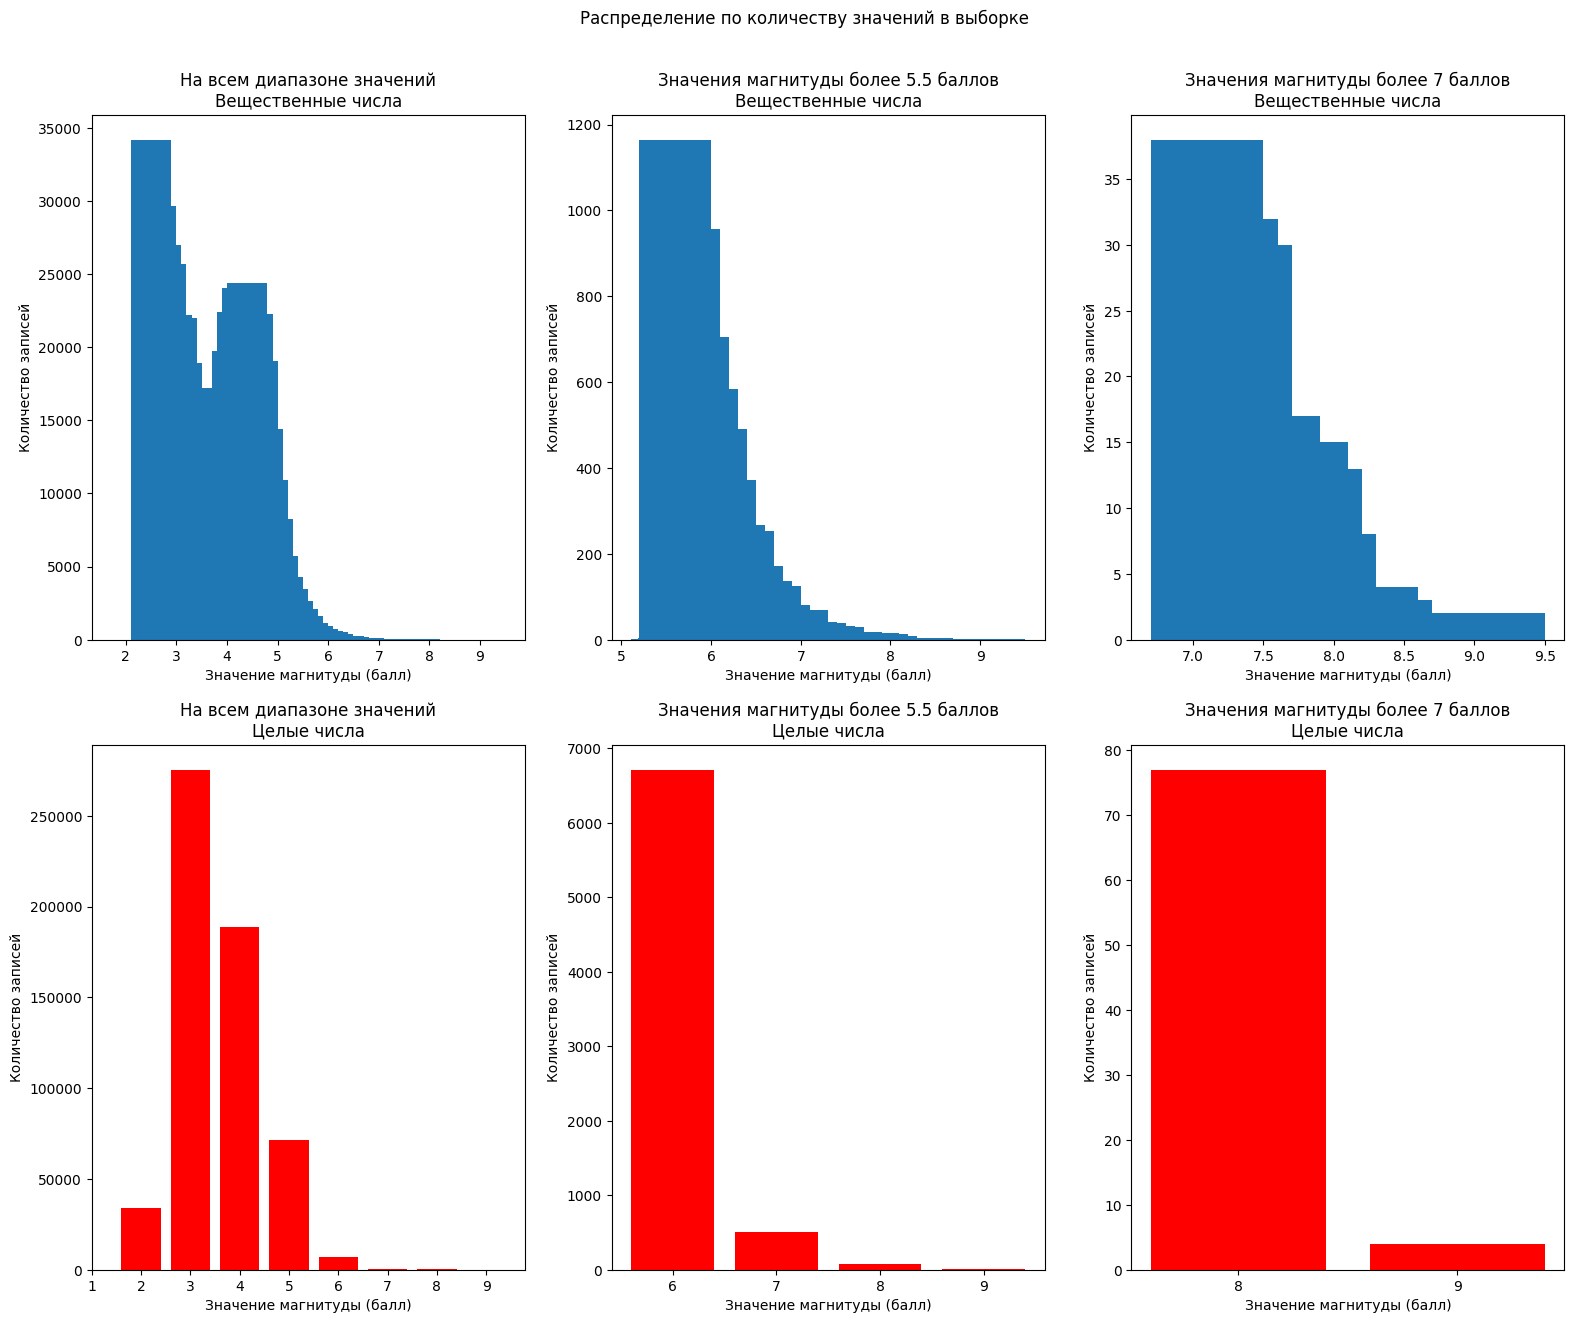

In [5]:
row, col = 2, 3

plt.figure(figsize=(19,15))
plt.suptitle('Распределение по количеству значений в выборке', y=0.95)

plt.subplot(row, col, 1)
plt.title('На всем диапазоне значений\nВещественные числа')
plt.bar(values_count.index.to_numpy(), values_count['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')

plt.subplot(row, col, 2)
plt.title('Значения магнитуды более 5.5 баллов\nВещественные числа')
plt.bar(values_count[values_count.index > 5.5].index.to_numpy(), values_count[values_count.index > 5.5]['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')

plt.subplot(row, col, 3)
plt.title('Значения магнитуды более 7 баллов\nВещественные числа')
plt.bar(values_count[values_count.index > 7].index.to_numpy(), values_count[values_count.index > 7]['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')


plt.subplot(row, col, 4)
plt.title('На всем диапазоне значений\nЦелые числа')
plt.bar(values_count_class.index.to_numpy(), values_count_class['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks(list(range(1,10)), list(range(1,10)))

plt.subplot(row, col, 5)
plt.title('Значения магнитуды более 5.5 баллов\nЦелые числа')
plt.bar(values_count_class[values_count_class.index > 5.5].index.to_numpy(), values_count_class[values_count_class.index > 5.5]['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks([6, 7, 8, 9], [6, 7, 8, 9])

plt.subplot(row, col, 6)
plt.title('Значения магнитуды более 7 баллов\nЦелые числа')
plt.bar(values_count_class[values_count_class.index > 7].index.to_numpy(), values_count_class[values_count_class.index > 7]['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks([8,9], [8,9])

plt.show()

На графике заметно значительное преобладание значений магнитуды от 2 до 5. Этот "Перекос", возможно, осложнит обучение модели в будущем. Решение этой проблемы будет приведено в разделе **3.1.**

## 2. Обучение моделей

### 2.1. Обучение модели регрессии на первичных данных, полученных из источника.


Нормализация признаков

In [6]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

Построение модели. 

По результатам ряда попыток, с различными конфигурациями модели (разное количество слоев, разные значения units слоя), был сделан вывод, что для достижения относительно качественных показателей не требуется большое количество слоев и значений units слоя.

In [7]:
quake_model = keras.Sequential()

quake_model.add(normalizer)
quake_model.add(layers.Dense(3, activation='elu'))
quake_model.add(layers.Dense(1, activation='elu'))
quake_model.add(layers.Dense(1))

quake_model.summary()
quake_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'mean_absolute_percentage_error', 'mean_absolute_error'],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 58)                117       
 on)                                                             
                                                                 
 dense (Dense)               (None, 3)                 177       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 300 (1.18 KB)
Trainable params: 183 (732.00 Byte)
Non-trainable params: 117 (472.00 Byte)
_________________________________________________________________


Обучение модели

In [8]:
history = quake_model.fit(
    train_features,
    train_labels,
    epochs=10,
    verbose=1,
    validation_data=(val_features.to_numpy(), val_labels.to_numpy())
)

Epoch 1/10
10823/10823 [==============================] - 8s 680us/step - loss: 0.7681 - mean_squared_error: 0.7681 - mean_absolute_percentage_error: 16.8617 - mean_absolute_error: 0.5890 - val_loss: 0.3860 - val_mean_squared_error: 0.3860 - val_mean_absolute_percentage_error: 13.6353 - val_mean_absolute_error: 0.4762
Epoch 2/10
10823/10823 [==============================] - 7s 668us/step - loss: 0.3783 - mean_squared_error: 0.3783 - mean_absolute_percentage_error: 13.6010 - mean_absolute_error: 0.4728 - val_loss: 0.3795 - val_mean_squared_error: 0.3795 - val_mean_absolute_percentage_error: 13.3995 - val_mean_absolute_error: 0.4686
Epoch 3/10
10823/10823 [==============================] - 7s 669us/step - loss: 0.3734 - mean_squared_error: 0.3734 - mean_absolute_percentage_error: 13.4435 - mean_absolute_error: 0.4674 - val_loss: 0.3766 - val_mean_squared_error: 0.3766 - val_mean_absolute_percentage_error: 13.4125 - val_mean_absolute_error: 0.4665
Epoch 4/10
10823/10823 [================

#### 2.1.1 Изучение результатов

In [9]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_squared_error,mean_absolute_percentage_error,mean_absolute_error,val_loss,val_mean_squared_error,val_mean_absolute_percentage_error,val_mean_absolute_error,epoch
5,0.366860,0.366860,13.237081,0.459968,0.371474,0.371474,13.170156,0.460357,5
6,0.365982,0.365982,13.215698,0.459125,0.370876,0.370876,13.072464,0.458551,6
7,0.365474,0.365474,13.210277,0.458914,0.369383,0.369383,13.098240,0.457879,7
8,0.364911,0.364911,13.198001,0.458388,0.372612,0.372612,13.242489,0.461558,8
9,0.364702,0.364702,13.189121,0.458085,0.370544,0.370544,13.349319,0.462965,9


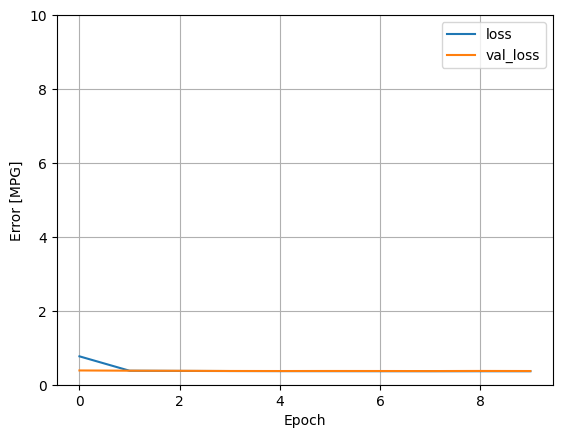

In [10]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [11]:
y_pred = quake_model.predict(test_features)
r2_score(test_labels.to_numpy(), y_pred)

4510/4510 [==============================] - 2s 429us/step


0.4787337183593191

In [12]:
quake_model.save('models/keras_regression')

INFO:tensorflow:Assets written to: models/keras_regression/assets


INFO:tensorflow:Assets written to: models/keras_regression/assets


### 2.2. Обучение модели классификации, на преобразованных данных.

#### Подготовка обучающей, валидационной и тестовой выборок.

Для моделей классификации необходима процедура преобразования массива ответов. Преобразование происходит с помощью функции keras.utils - **to_categorical()**

In [13]:
# Разбиение датасета на обучающий, валидационный и тестовый
df_class_train, df_class_val, df_class_test = split_stratified_into_train_val_test(quakes_class_df.drop(['Date'], axis=1), 'Magnitude')

# Подготовка признаков и значений
train_class_features = df_class_train.copy()
test_class_features = df_class_val.copy()
val_class_features = df_class_test.copy()

train_labels = train_class_features.pop('Magnitude')
test_labels_class = test_class_features.pop('Magnitude')
val_labels = val_class_features.pop('Magnitude')

nb_classes = 10
y_train = to_categorical(train_labels.to_numpy().astype(int), nb_classes)
y_test = to_categorical(test_labels_class.to_numpy().astype(int), nb_classes)
y_val = to_categorical(val_labels.to_numpy().astype(int), nb_classes)

normalizer_class = tf.keras.layers.Normalization(axis=-1)
normalizer_class.adapt(np.array(train_class_features))

Построение модели. 

По результатам ряда попыток, с различными конфигурациями модели (разное количество слоев, разные значения units слоя), был сделан вывод, что для достижения относительно качественных показателей не требуется большое количество слоев и значений units слоя.

Функция активации последнего слоя в случае применения sigmoid и softmax показала сопоставимое качество модели.

In [14]:
quake_class_model = keras.Sequential()

quake_class_model.add(normalizer_class)
quake_class_model.add(layers.Dense(3, activation='relu'))
quake_class_model.add(layers.Dense(1, activation='relu'))
quake_class_model.add(layers.Dense(nb_classes, activation='softmax'))

quake_class_model.summary()
quake_class_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', [Recall(), Precision(), F1Score()]]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 58)                117       
 tion)                                                           
                                                                 
 dense_3 (Dense)             (None, 3)                 177       
                                                                 
 dense_4 (Dense)             (None, 1)                 4         
                                                                 
 dense_5 (Dense)             (None, 10)                20        
                                                                 
Total params: 318 (1.25 KB)
Trainable params: 201 (804.00 Byte)
Non-trainable params: 117 (472.00 Byte)
_________________________________________________________________


Обучение модели

In [15]:
history = quake_class_model.fit(
    train_class_features,
    y_train,
    epochs=10,
    verbose=1,
    validation_data=(val_class_features.to_numpy(), y_val)
)

Epoch 1/10
10823/10823 [==============================] - 10s 840us/step - loss: 1.0877 - accuracy: 0.5955 - recall: 0.4012 - precision: 0.6671 - f1_score: 0.1284 - val_loss: 0.9316 - val_accuracy: 0.6444 - val_recall: 0.5709 - val_precision: 0.6652 - val_f1_score: 0.1381
Epoch 2/10
10823/10823 [==============================] - 9s 820us/step - loss: 0.9293 - accuracy: 0.6439 - recall: 0.5774 - precision: 0.6639 - f1_score: 0.1385 - val_loss: 0.9244 - val_accuracy: 0.6444 - val_recall: 0.5749 - val_precision: 0.6661 - val_f1_score: 0.1388
Epoch 3/10
10823/10823 [==============================] - 9s 818us/step - loss: 0.9252 - accuracy: 0.6468 - recall: 0.5866 - precision: 0.6647 - f1_score: 0.1391 - val_loss: 0.9210 - val_accuracy: 0.6504 - val_recall: 0.5916 - val_precision: 0.6685 - val_f1_score: 0.1399
Epoch 4/10
10823/10823 [==============================] - 9s 822us/step - loss: 0.9235 - accuracy: 0.6494 - recall: 0.5906 - precision: 0.6656 - f1_score: 0.1397 - val_loss: 0.9186 - 

#### 2.2.1 Изучение результатов

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,recall,precision,f1_score,val_loss,val_accuracy,val_recall,val_precision,val_f1_score,epoch
5,0.922550,0.649886,0.592451,0.666096,"[0.0, 0.0, 0.0, 0.79046404, 0.60792613, 0.0, 0...",0.919580,0.651216,0.601281,0.667233,"[0.0, 0.0, 0.0, 0.7912342, 0.6086086, 0.0, 0.0...",5
6,0.922475,0.650187,0.594330,0.666248,"[0.0, 0.0, 0.0, 0.79074585, 0.60823625, 0.0, 0...",0.918924,0.650966,0.591198,0.669339,"[0.0, 0.0, 0.0, 0.7902506, 0.61183023, 0.0, 0....",6
7,0.922117,0.650319,0.593967,0.666138,"[0.0, 0.0, 0.0, 0.7908597, 0.6084812, 0.0, 0.0...",0.917348,0.653239,0.598031,0.668800,"[0.0, 0.0, 0.0, 0.79352504, 0.6094647, 0.0, 0....",7
8,0.922070,0.650446,0.594711,0.666667,"[0.0, 0.0, 0.0, 0.79094803, 0.6085718, 0.0, 0....",0.919916,0.649802,0.601946,0.667074,"[0.0, 0.0, 0.0, 0.7905701, 0.6022225, 0.0, 0.0...",8
9,0.921980,0.650256,0.594986,0.666679,"[0.0, 0.0, 0.0, 0.79077095, 0.60832465, 0.0, 0...",0.919663,0.649927,0.595938,0.667262,"[0.0, 0.0, 0.0, 0.789992, 0.6051171, 0.0, 0.0,...",9


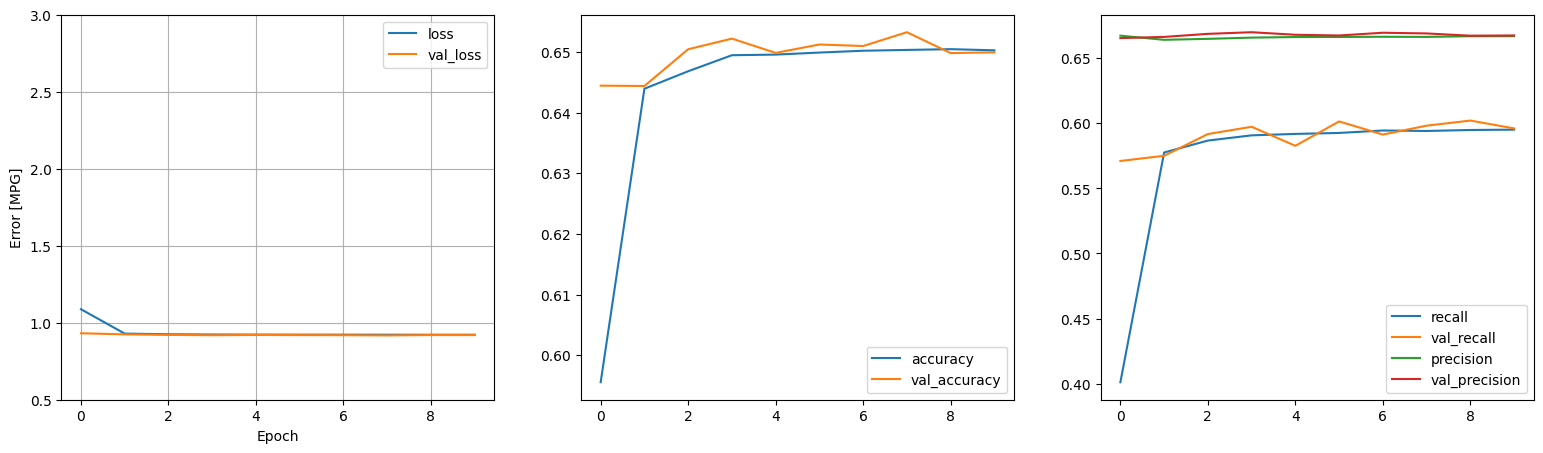

In [17]:
def plot_loss(history, num = ''):
    plt.figure(figsize=(19,5))
    row, col = 1, 3
    plt.subplot(row, col, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0.5, 3])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

    plt.subplot(row, col, 2)
    #plt.ylim([0.475, 0.480])
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()

    plt.subplot(row, col, 3)
    
    plt.plot(history.history[f'recall{num}'], label='recall')
    plt.plot(history.history[f'val_recall{num}'], label='val_recall')
    plt.plot(history.history[f'precision{num}'], label='precision')
    plt.plot(history.history[f'val_precision{num}'], label='val_precision')
    plt.legend()

plot_loss(history)

Посмотрим какие присутствуют ответы

In [18]:
y_pred = quake_class_model.predict(test_class_features)

answer = []
for row in y_pred:
    answer.append(np.argmax(row))

np.unique(np.array(answer))

2706/2706 [==============================] - 1s 434us/step


array([3, 4])

In [21]:
print(classification_report(test_labels_class, answer))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00      5058
           3       0.69      0.92      0.79     41190
           4       0.58      0.64      0.61     28494
           5       0.00      0.00      0.00     10749
           6       0.00      0.00      0.00      1008
           7       0.00      0.00      0.00        75
           8       0.00      0.00      0.00        10

    accuracy                           0.65     86584
   macro avg       0.18      0.22      0.20     86584
weighted avg       0.52      0.65      0.57     86584



/home/zorkin/Yandex.Disk/Обучение/Python/2023/temblor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zorkin/Yandex.Disk/Обучение/Python/2023/temblor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zorkin/Yandex.Disk/Обучение/Python/2023/temblor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

In [22]:
quake_class_model.save('models/keras_classification')

INFO:tensorflow:Assets written to: models/keras_classification/assets


INFO:tensorflow:Assets written to: models/keras_classification/assets


# 3. Обучение модели на равномерно распределенных данных

## 3.1. Обогащение данных датасета

Цель обогащения - достичь сопоставимого количества событий в каждой группе. Для обогащения в каждой группе каждое событие увеличивается в кратное количество раз:
- дата события не меняется
- координаты распределяются в диапазоне 0,5 градуса долготы исходного события.

Правило кратности для каждой группы заносятся в словарь **enrich_rule**

In [23]:
import time
start_time = time.time()

enrich_rule = {
    2: 2,
    5: 2,
    6: 20,
    7: 150,
    8: 500,
    9: 1500,
}

table = 'quakes_class_enrich'
column = 'Magnitude'

for magnitude, new_incident_count in enrich_rule.items():
    print(f'start enrich for {magnitude} magnitude up to {new_incident_count} new rows in one incident')

    enrichment = Enrichment(table, column, magnitude, new_incident_count)
    upload_df(enrichment.start_add(), table=table)

    end_time = time.time()
    delta = (end_time  - start_time) / 60
    print(f'finish enrich for {magnitude} magnitude in {delta} min')
    start_time = end_time

start enrich for 2 magnitude up to 2 new rows in one incident
None
finish enrich for 2 magnitude in 9.600146226088206 min
start enrich for 5 magnitude up to 2 new rows in one incident
None
finish enrich for 5 magnitude in 42.25204947392146 min
start enrich for 6 magnitude up to 20 new rows in one incident
None
finish enrich for 6 magnitude in 2.3730406800905866 min
start enrich for 7 magnitude up to 150 new rows in one incident
None
finish enrich for 7 magnitude in 0.1597091794013977 min
start enrich for 8 magnitude up to 500 new rows in one incident
None
finish enrich for 8 magnitude in 0.05447646776835124 min
start enrich for 9 magnitude up to 1500 new rows in one incident
None
finish enrich for 9 magnitude in 0.008179903030395508 min


Загрузка обогащенных данных

In [24]:
quakes_class_df_enrich: pd.DataFrame = client.query_df('SELECT * FROM quakes_class_enrich ORDER BY Date')

values_count_class_enrich = quakes_class_df_enrich['Magnitude'].value_counts().to_frame().sort_values('Magnitude')

values_count_class_enrich['rate'] = 275374 / values_count_class_enrich['count']
values_count_class_enrich

,count,rate
Magnitude,,
2,136796,2.013027
3,275466,0.999666
4,189026,1.456805
5,284964,0.966347
6,147664,1.864869
7,76304,3.608906
8,38654,7.124075
9,6008,45.834554


Просмотр результата

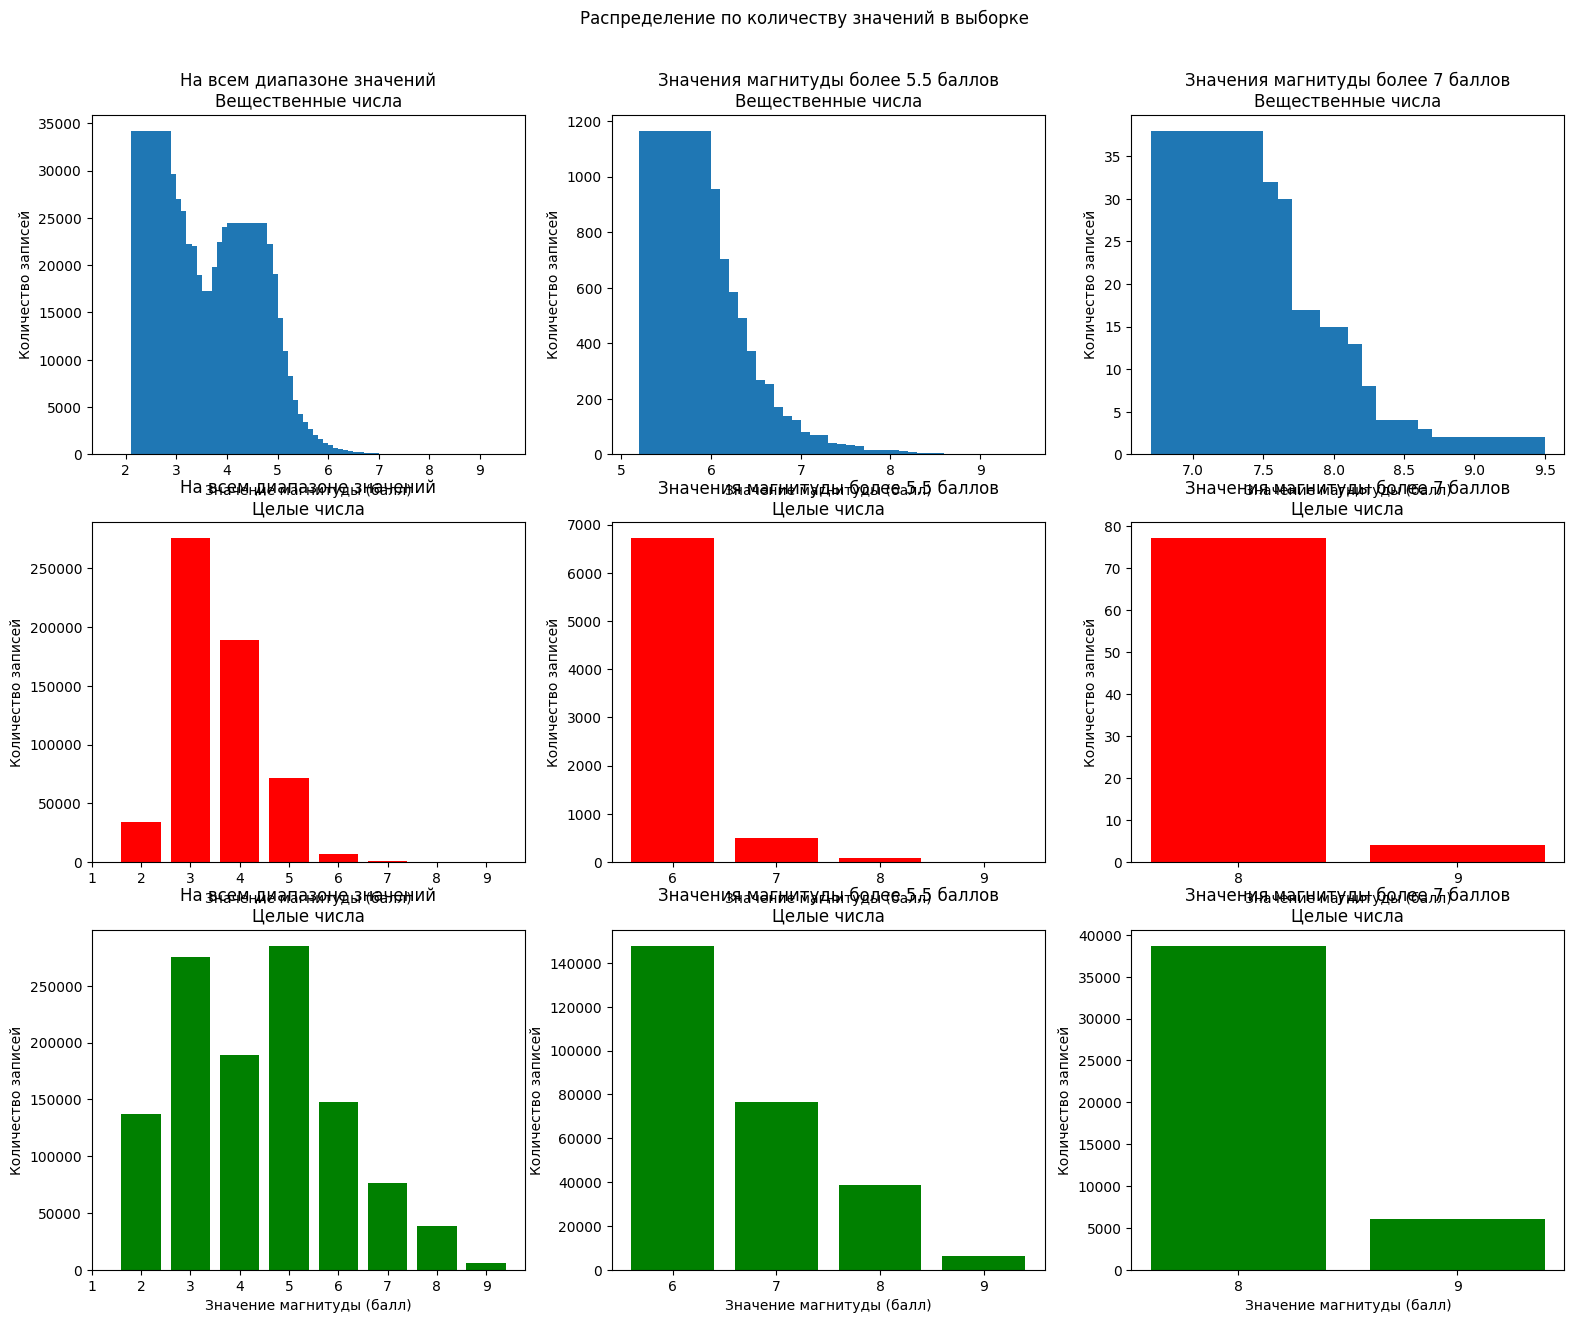

In [25]:
row, col = 3, 3
plt.figure(figsize=(19,15))
plt.suptitle('Распределение по количеству значений в выборке', y=0.95)

plt.subplot(row, col, 1)
plt.title('На всем диапазоне значений\nВещественные числа')
plt.bar(values_count.index.to_numpy(), values_count['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')

plt.subplot(row, col, 2)
plt.title('Значения магнитуды более 5.5 баллов\nВещественные числа')
plt.bar(values_count[values_count.index > 5.5].index.to_numpy(), values_count[values_count.index > 5.5]['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')

plt.subplot(row, col, 3)
plt.title('Значения магнитуды более 7 баллов\nВещественные числа')
plt.bar(values_count[values_count.index > 7].index.to_numpy(), values_count[values_count.index > 7]['count'])
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')


plt.subplot(row, col, 4)
plt.title('На всем диапазоне значений\nЦелые числа')
plt.bar(values_count_class.index.to_numpy(), values_count_class['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks(list(range(1,10)), list(range(1,10)))

plt.subplot(row, col, 5)
plt.title('Значения магнитуды более 5.5 баллов\nЦелые числа')
plt.bar(values_count_class[values_count_class.index > 5.5].index.to_numpy(), values_count_class[values_count_class.index > 5.5]['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks([6, 7, 8, 9], [6, 7, 8, 9])

plt.subplot(row, col, 6)
plt.title('Значения магнитуды более 7 баллов\nЦелые числа')
plt.bar(values_count_class[values_count_class.index > 7].index.to_numpy(), values_count_class[values_count_class.index > 7]['count'], color='r')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks([8,9], [8,9])


plt.subplot(row, col, 7)
plt.title('На всем диапазоне значений\nЦелые числа')
plt.bar(values_count_class_enrich.index.to_numpy(), values_count_class_enrich['count'], color='g')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks(list(range(1,10)), list(range(1,10)))

plt.subplot(row, col, 8)
plt.title('Значения магнитуды более 5.5 баллов\nЦелые числа')
plt.bar(values_count_class_enrich[values_count_class_enrich.index > 5.5].index.to_numpy(), values_count_class_enrich[values_count_class_enrich.index > 5.5]['count'], color='g')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks([6, 7, 8, 9], [6, 7, 8, 9])

plt.subplot(row, col, 9)
plt.title('Значения магнитуды более 7 баллов\nЦелые числа')
plt.bar(values_count_class_enrich[values_count_class_enrich.index > 7].index.to_numpy(), values_count_class_enrich[values_count_class_enrich.index > 7]['count'], color='g')
plt.xlabel('Значение магнитуды (балл)')
plt.ylabel('Количество записей')
plt.xticks([8,9], [8,9])

plt.show()

Подготовка данных для обучения

In [28]:
# Разбиение датасета на обучающий, валидационный и тестовый
df_class_train, df_class_val, df_class_test = split_stratified_into_train_val_test(quakes_class_df_enrich.drop(['Date'], axis=1), 'Magnitude')

# Подготовка признаков и значений
train_class_features = df_class_train.copy()
test_class_features_enrich = df_class_val.copy()
val_class_features = df_class_test.copy()

train_labels = train_class_features.pop('Magnitude')
test_labels_class_enrich = test_class_features_enrich.pop('Magnitude')
val_labels = val_class_features.pop('Magnitude')

nb_classes = 10
y_train = to_categorical(train_labels.to_numpy().astype(int), nb_classes)
y_test = to_categorical(test_labels_class_enrich.to_numpy().astype(int), nb_classes)
y_val = to_categorical(val_labels.to_numpy().astype(int), nb_classes)

normalizer_class = tf.keras.layers.Normalization(axis=-1)
normalizer_class.adapt(np.array(train_class_features))

Подготовка модели

In [29]:
quake_class_model = keras.Sequential()

quake_class_model.add(normalizer_class)
quake_class_model.add(layers.Dense(3, activation='relu'))
quake_class_model.add(layers.Dense(1, activation='relu'))
quake_class_model.add(layers.Dense(nb_classes, activation='softmax'))

quake_class_model.summary()
quake_class_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', [Recall(), Precision(), F1Score()]]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normaliza  (None, 58)                117       
 tion)                                                           
                                                                 
 dense_6 (Dense)             (None, 3)                 177       
                                                                 
 dense_7 (Dense)             (None, 1)                 4         
                                                                 
 dense_8 (Dense)             (None, 10)                20        
                                                                 
Total params: 318 (1.25 KB)
Trainable params: 201 (804.00 Byte)
Non-trainable params: 117 (472.00 Byte)
_________________________________________________________________


Обучение модели

In [30]:
history = quake_class_model.fit(
    train_class_features,
    y_train,
    epochs=10,
    verbose=1,
    validation_data=(val_class_features.to_numpy(), y_val)
)

Epoch 1/10
21655/21655 [==============================] - 20s 886us/step - loss: 1.5689 - accuracy: 0.4118 - recall_1: 0.0839 - precision_1: 0.5042 - f1_score: 0.1135 - val_loss: 1.5145 - val_accuracy: 0.4260 - val_recall_1: 0.1092 - val_precision_1: 0.5184 - val_f1_score: 0.1148
Epoch 2/10
21655/21655 [==============================] - 18s 826us/step - loss: 1.5148 - accuracy: 0.4226 - recall_1: 0.1011 - precision_1: 0.5187 - f1_score: 0.1177 - val_loss: 1.5130 - val_accuracy: 0.4243 - val_recall_1: 0.0853 - val_precision_1: 0.5391 - val_f1_score: 0.1156
Epoch 3/10
21655/21655 [==============================] - 18s 829us/step - loss: 1.5133 - accuracy: 0.4227 - recall_1: 0.1017 - precision_1: 0.5195 - f1_score: 0.1185 - val_loss: 1.5111 - val_accuracy: 0.4250 - val_recall_1: 0.0989 - val_precision_1: 0.5224 - val_f1_score: 0.1259
Epoch 4/10
21655/21655 [==============================] - 18s 831us/step - loss: 1.5126 - accuracy: 0.4228 - recall_1: 0.1010 - precision_1: 0.5190 - f1_scor

### 3.1.1. Изучение результатов

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,recall_1,precision_1,f1_score,val_loss,val_accuracy,val_recall_1,val_precision_1,val_f1_score,epoch
5,1.511898,0.423082,0.099608,0.516663,"[0.0, 0.0, 0.0, 0.60567784, 0.050270326, 0.536...",1.511801,0.421840,0.098105,0.511245,"[0.0, 0.0, 0.0, 0.6049863, 0.10077349, 0.53550...",5
6,1.511550,0.422932,0.099739,0.517031,"[0.0, 0.0, 0.0, 0.6054671, 0.052858636, 0.5363...",1.510041,0.424389,0.110498,0.511939,"[0.0, 0.0, 0.0, 0.6075206, 0.10981519, 0.53803...",6
7,1.511279,0.423149,0.099987,0.516078,"[0.0, 0.0, 0.0, 0.6061192, 0.053020008, 0.5362...",1.510520,0.422716,0.106490,0.516748,"[0.0, 0.0, 0.0, 0.60567737, 0.0047891107, 0.53...",7
8,1.511214,0.422938,0.100338,0.517742,"[0.0, 0.0, 0.0, 0.6054948, 0.05374138, 0.53630...",1.510875,0.423914,0.129395,0.505261,"[0.0, 0.0, 0.0, 0.60653275, 0.016694011, 0.535...",8
9,1.511090,0.423191,0.099925,0.516285,"[0.0, 0.0, 0.0, 0.60598904, 0.053203076, 0.536...",1.510180,0.422803,0.109563,0.518582,"[0.0, 0.0, 0.0, 0.6060838, 0.0, 0.53347754, 0....",9


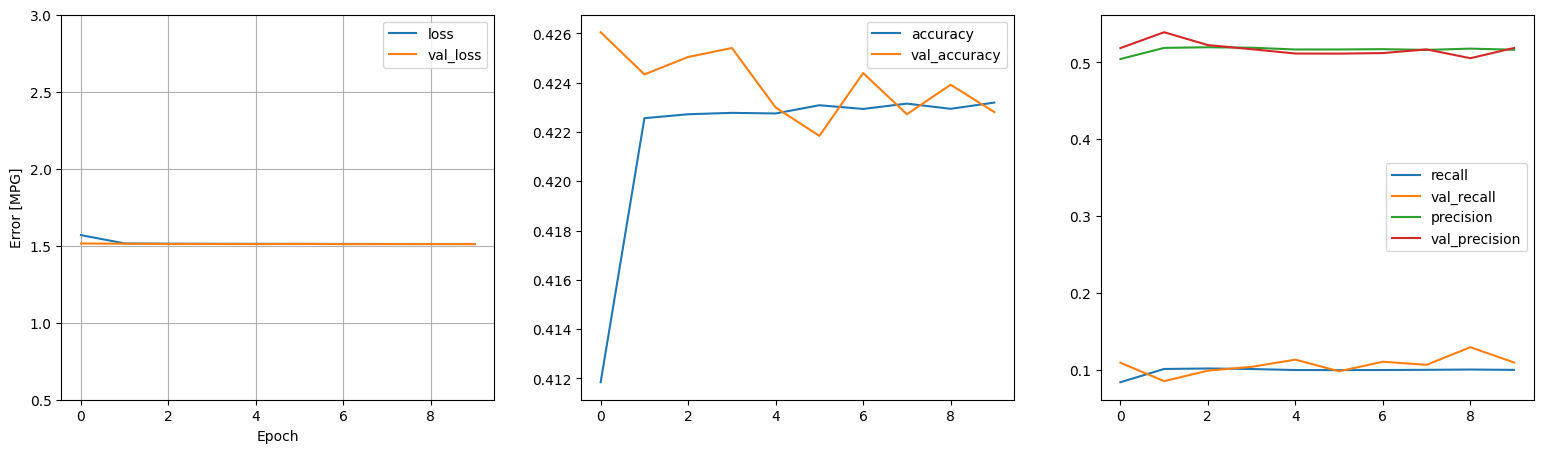

In [32]:
plot_loss(history, '_1')

In [33]:
y_pred = quake_class_model.predict(test_class_features)

answer = []
for row in y_pred:
    answer.append(np.argmax(row))

np.unique(np.array(answer))

2706/2706 [==============================] - 1s 452us/step


array([3, 5])

In [35]:
print(classification_report(test_labels_class, answer))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00      5058
           3       0.68      0.92      0.78     41190
           4       0.00      0.00      0.00     28494
           5       0.28      0.83      0.42     10749
           6       0.00      0.00      0.00      1008
           7       0.00      0.00      0.00        75
           8       0.00      0.00      0.00        10

    accuracy                           0.54     86584
   macro avg       0.14      0.25      0.17     86584
weighted avg       0.36      0.54      0.42     86584



/home/zorkin/Yandex.Disk/Обучение/Python/2023/temblor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zorkin/Yandex.Disk/Обучение/Python/2023/temblor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zorkin/Yandex.Disk/Обучение/Python/2023/temblor/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

In [36]:
quake_class_model.save('models/keras_classification_enrich')

INFO:tensorflow:Assets written to: models/keras_classification_enrich/assets


INFO:tensorflow:Assets written to: models/keras_classification_enrich/assets


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression # Импортируем класс LinearRegression
from sklearn.preprocessing import PolynomialFeatures


X = np.array([[5, 10, 25, 40, 50, 60], [502, 502, 502, 502, 502, 502]]) # Значения признака
y = np.array([3.8, 10, 30.6, 67.6, 96, 143]) # Значение целевой переменной

X_ = X.reshape(-1,1) # Преобразуем X
reg = Pipeline([('quad', PolynomialFeatures(degree=3)),
                ('lr', LinearRegression())]) # Создаем экземпляр класса
reg.fit(X.T, y) # Обучаем
reg.score(X.T, y) # Оценка качества

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(X[0,:], X[1,:], y)

In [37]:
model_regr = keras.models.load_model('models/keras_regression')
model_class = keras.models.load_model('models/keras_classification')
model_class_enrich = keras.models.load_model('models/keras_classification_enrich/')

In [38]:
def to_class(y_predict):
    answer = []
    for row in y_predict:
        answer.append(np.argmax(row))

    return np.array(answer)

In [39]:
y_reg = model_regr.predict(test_features)
y_class = to_class(model_class.predict(test_class_features))
y_class_enrich = to_class(model_class_enrich.predict(test_class_features))

y_test = test_labels.to_numpy()
y_test_class = test_labels_class.to_numpy()

2706/2706 [==============================] - 2s 545us/step


In [48]:
quake_slice = 100

x_reg = np.arange(1, len(y_test),1)[:quake_slice]
pic_y_reg = y_reg[:quake_slice]

x_class = np.arange(1, len(y_test_class),1)[:quake_slice]
pic_y_class = y_class[:quake_slice]
pic_y_class_enrich = y_class_enrich[:quake_slice]

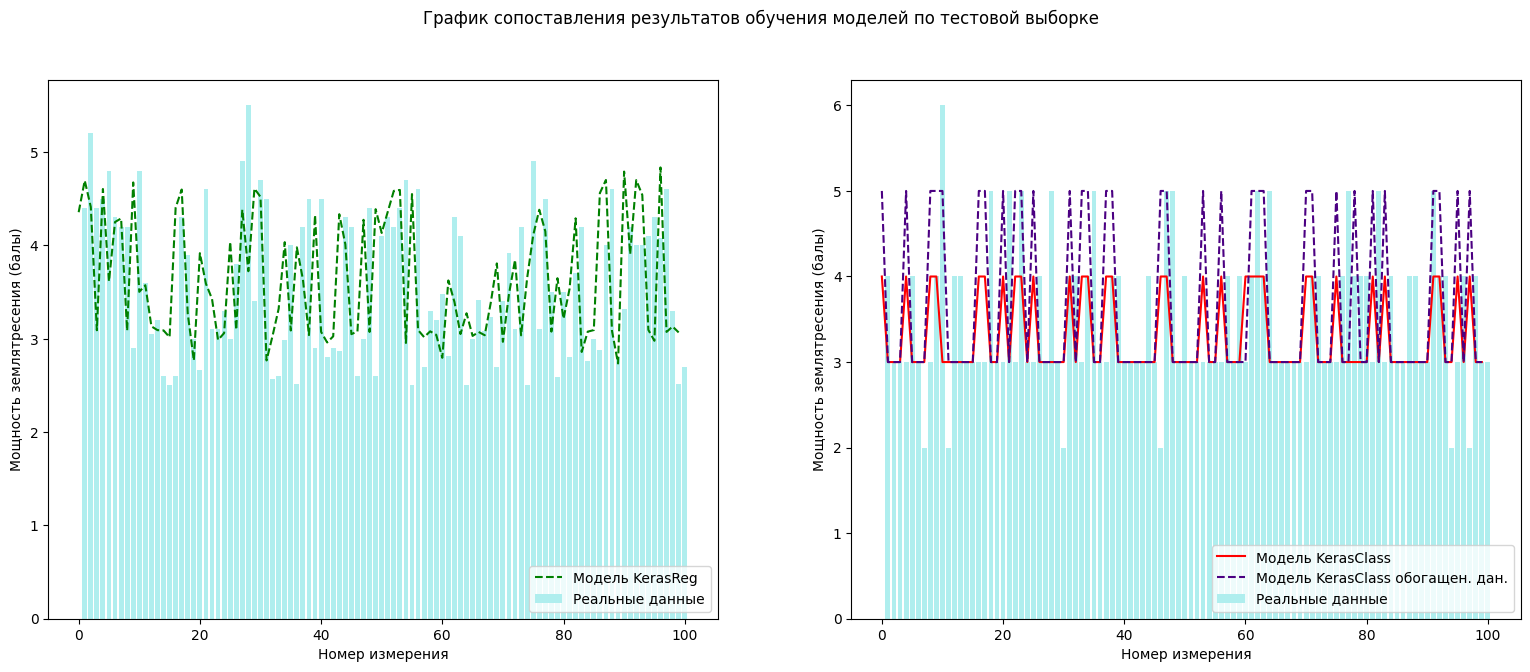

In [49]:
plt.figure(figsize=(19,7))
plt.suptitle('График сопоставления результатов обучения моделей по тестовой выборке')


plt.subplot(1,2,1)
plt.bar(x_reg, y_test[:quake_slice],label='Реальные данные', color='#AFEEEE')
plt.plot(pic_y_reg, '--', color='g', label='Модель KerasReg')
plt.xlabel('Номер измерения')
plt.ylabel('Мощность землятресения (балы)')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.bar(x_class, y_test_class[:quake_slice],label='Реальные данные', color='#AFEEEE')
plt.plot(pic_y_class, '-r', label='Модель KerasClass')
plt.plot(pic_y_class_enrich, '--', color='#4B0082', label='Модель KerasClass обогащен. дан.')

plt.xlabel('Номер измерения')
plt.ylabel('Мощность землятресения (балы)')
plt.legend(loc='lower right')

plt.show()